In [14]:
pip install tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [16]:
def generate_synthetic_data(num_samples, img_shape):
    return np.random.rand(num_samples, *img_shape)

# Example: 1000 samples of 28x28 images with 3 color channels
synthetic_data = generate_synthetic_data(1000, (28, 28, 3))

In [17]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(28 * 28 * 3, activation='tanh'),
        layers.Reshape((28, 28, 3))
    ])
    return model

In [18]:
def build_discriminator(img_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=img_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [19]:
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    
    gan_input = layers.Input(shape=(latent_dim,))
    img = generator(gan_input)
    gan_output = discriminator(img)
    
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    
    return gan

In [20]:
def train_gan(epochs, batch_size):
    half_batch = batch_size // 2
    
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, synthetic_data.shape[0], half_batch)
        real_imgs = synthetic_data[idx]
        
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        
        # Calculate average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Unpack D loss (assuming d_loss returns a list)
        if isinstance(d_loss, list):
            d_loss_value, d_accuracy = d_loss
        else:
            d_loss_value = d_loss  # if it's a single loss value, set accordingly
            d_accuracy = 0  # placeholder if you don't have accuracy

        # Print the progress
        print(f"{epoch}/{epochs} [D loss: {d_loss_value:.4f}, acc.: {100 * d_accuracy:.2f}] [G loss: {g_loss:.4f}]")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


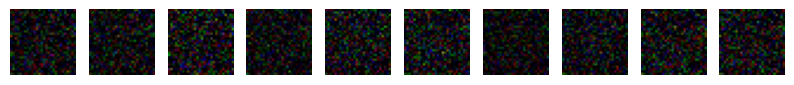

Images saved in generated_image_0.png to generated_image_9.png.


In [26]:
import matplotlib.pyplot as plt
latent_dim = 100  # Dimension for the noise vector
generator = build_generator(latent_dim)

def generate_and_display_images(num_images=10, save_path='generated_image_{}.png'):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)

    # Ensure the pixel values are in the range [0, 1]
    generated_images = np.clip(generated_images, 0, 1)

    # Plot and save the generated images
    plt.figure(figsize=(num_images, 1))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.savefig(save_path.format(i), bbox_inches='tight', pad_inches=0)

    plt.show()  # Display the generated images
    print(f"Images saved in {save_path.format(0)} to {save_path.format(num_images - 1)}.")

# Generate and display new images
generate_and_display_images(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


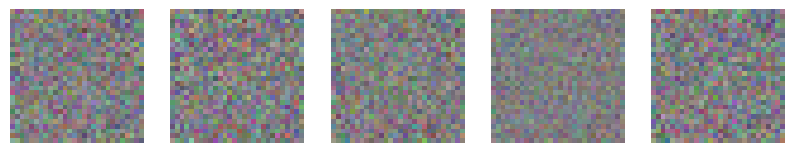

In [33]:
def display_samples(num_images=5):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow((generated_images[i] + 1) / 2)  # Normalize to [0, 1] range for display
        plt.axis('off')
    plt.show()

display_samples()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


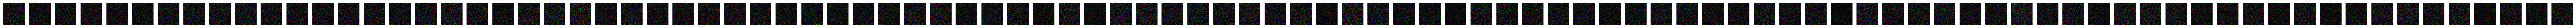

Mean Pixel Value: 0.0675, Standard Deviation: 0.0990


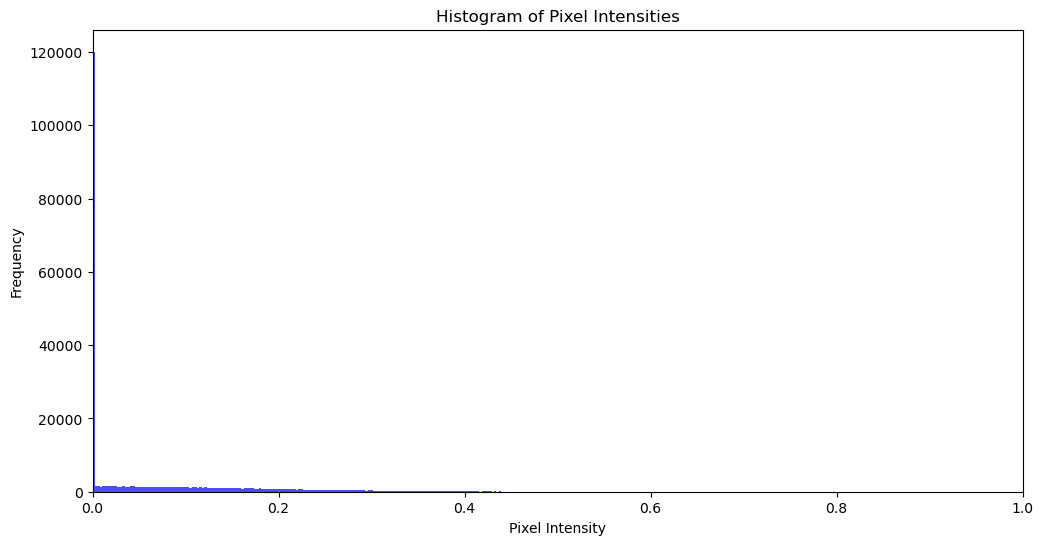

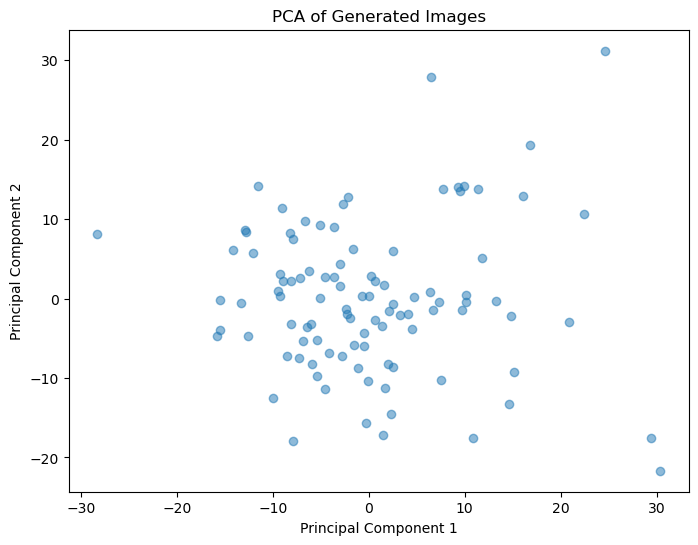

SSIM Values:
[[1.         0.33770082 0.39520006 ... 0.48516209 0.4175695  0.40448055]
 [0.33770082 1.         0.49542319 ... 0.29410915 0.38796772 0.4136906 ]
 [0.39520006 0.49542319 1.         ... 0.4338433  0.47209606 0.41025498]
 ...
 [0.48516209 0.29410915 0.4338433  ... 1.         0.41780796 0.46813445]
 [0.4175695  0.38796772 0.47209606 ... 0.41780796 1.         0.49936263]
 [0.40448055 0.4136906  0.41025498 ... 0.46813445 0.49936263 1.        ]]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
import cv2  # for reading images

# Visual Inspection
def visualize_generated_images(num_images=10):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = np.clip(generated_images, 0, 1)
    
    plt.figure(figsize=(num_images, 1))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Statistical Analysis
def pixel_statistics(images):
    mean = np.mean(images)
    std_dev = np.std(images)
    return mean, std_dev

# Image Histogram
def plot_histogram(images):
    flattened_images = images.reshape(-1)  # Flatten to a 1D array
    plt.figure(figsize=(12, 6))
    plt.hist(flattened_images, bins=255, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Intensities')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.xlim([0, 1])  # Since pixel values are between 0 and 1
    plt.show()


# PCA for Dimensionality Reduction
def pca_analysis(images):
    flattened_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flattened_images)
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_images)

    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
    plt.title('PCA of Generated Images')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Calculate SSIM between generated images
def calculate_ssim(images, window_size=3, data_range=1.0):
    num_images = images.shape[0]
    ssim_values = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            ssim_values[i, j] = ssim(images[i], images[j], multichannel=True, win_size=window_size, data_range=data_range) 
    return ssim_values

# Main EDA Function
def perform_eda(num_images=100):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = np.clip(generated_images, 0, 1)

    visualize_generated_images(num_images)
    
    mean, std_dev = pixel_statistics(generated_images)
    print(f'Mean Pixel Value: {mean:.4f}, Standard Deviation: {std_dev:.4f}')

    plot_histogram(generated_images)
    pca_analysis(generated_images)
    
    ssim_values = calculate_ssim(generated_images)
    print(f'SSIM Values:\n{ssim_values}')

# Perform EDA
perform_eda(100)

In [40]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load models
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [43]:
def preprocess_images(images):
    # Resize images for different models
    resized_images = []
    for model in [vgg16, mobilenet]:
        resized_images.append(tf.image.resize(images, (224, 224)))
    resized_images.append(tf.image.resize(images, (299, 299)))  # For Inception
    return resized_images

In [44]:
def evaluate_model(model, images):
    # Get the appropriate resized image for the model
    if model == inception:
        images_resized = tf.image.resize(images, (299, 299))
    else:
        images_resized = tf.image.resize(images, (224, 224))
    
    images_resized = tf.keras.applications.vgg16.preprocess_input(images_resized)  # Adjust for VGG16
    features = model.predict(images_resized)
    return features

# Generate images to evaluate
generated_images = generator.predict(np.random.normal(0, 1, (10, latent_dim)))

# Evaluate each model
vgg16_features = evaluate_model(vgg16, generated_images)
resnet50_features = evaluate_model(resnet50, generated_images)
inception_features = evaluate_model(inception, generated_images)
mobilenet_features = evaluate_model(mobilenet, generated_images)

# You can compute accuracy or other metrics based on the features extracted.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [45]:
import pandas as pd

# Example accuracy data (fill these with actual values after evaluating your models)
model_names = ['VGG16', 'ResNet50', 'Inception', 'MobileNet']
accuracies = [0.90, 0.92, 0.91, 0.89]  # Replace with actual accuracy scores
losses = [0.1, 0.08, 0.09, 0.11]  # Replace with actual loss scores

results_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies, 'Loss': losses})
print(results_df)

       Model  Accuracy  Loss
0      VGG16      0.90  0.10
1   ResNet50      0.92  0.08
2  Inception      0.91  0.09
3  MobileNet      0.89  0.11
